In [192]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor


data = pd.read_csv("development.csv",index_col=0)  
data=data.drop(columns=['url']) 

X_d = pd.get_dummies(data)

X_d.fillna(0, inplace=True)
X = X_d.drop('shares', axis=1) 
y = data['shares']  

# Preprocessing

Z normalization

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
columns = X.columns
X[columns] = scaler.fit_transform(X[columns])
X.describe()

y cut:

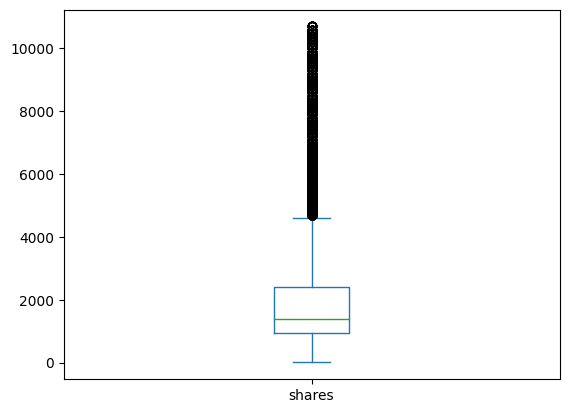

In [194]:
percentile = np.percentile(y, 95)
y_c = y[y <= percentile]

y_c.plot.box()
X = X.iloc[y_c.index]


Features importance

In [195]:
def features_importance_rmse(X_check, y_check):
    X_check.fillna(0, inplace=True)
    features = X_check.keys()
    X_train, X_valid, y_train, y_valid = train_test_split(X_check, y_check,test_size=0.2, random_state=0)

    reg = RandomForestRegressor(random_state=42)
    reg.fit(X_train , y_train)
    print(f"RMSE= {mean_squared_error(y_valid, reg.predict(X_valid))**0.5}")
    return sorted(zip(features, reg.feature_importances_), key=lambda x: x[1], reverse=True)

features_imp = features_importance_rmse(X, y_c)
features_imp

RMSE= 1768.3377555817162


[('kw_avg_avg', 0.07361103475899776),
 ('LDA_00', 0.03527957280936451),
 ('kw_max_avg', 0.0348794453783393),
 ('timedelta', 0.03411360640533124),
 ('LDA_01', 0.03264176362839656),
 ('kw_avg_max', 0.03154026828781368),
 ('average_token_length', 0.030534273748931792),
 ('global_subjectivity', 0.029288598271320396),
 ('LDA_04', 0.029254411601607532),
 ('LDA_02', 0.028544385311858447),
 ('n_non_stop_unique_tokens', 0.02803885391140493),
 ('self_reference_min_shares', 0.028023808271887427),
 ('LDA_03', 0.027807524444793997),
 ('n_unique_tokens', 0.027629443527314154),
 ('kw_avg_min', 0.02703806595089275),
 ('avg_positive_polarity', 0.026821437679294843),
 ('n_tokens_content', 0.026793028181624826),
 ('self_reference_avg_sharess', 0.026545199008341833),
 ('global_rate_positive_words', 0.025676196072401538),
 ('num_hrefs', 0.024164608622544343),
 ('global_sentiment_polarity', 0.023738025616067165),
 ('avg_negative_polarity', 0.02341735486311517),
 ('kw_max_min', 0.022752236271063285),
 ('kw_m

In [196]:
features_imp_columns = [x[0] for x in features_imp]
features_imp_columns = features_imp_columns[:40]

Correlation Cut

/var/folders/4_/w0yz4xkd559bc878fy5g6cv40000gn/T/ipykernel_1502/2379960244.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['shares'] = y


kw_avg_avg                      0.167358
LDA_00                          0.046705
kw_max_avg                      0.074066
timedelta                       0.027641
LDA_01                         -0.050409
kw_avg_max                      0.032193
average_token_length           -0.038976
global_subjectivity             0.047667
LDA_04                          0.048581
LDA_02                         -0.128753
n_non_stop_unique_tokens       -0.053567
self_reference_min_shares       0.051986
LDA_03                          0.073838
n_unique_tokens                -0.043396
kw_avg_min                      0.022187
avg_positive_polarity           0.015757
n_tokens_content                0.030292
self_reference_avg_sharess      0.062220
global_rate_positive_words      0.045871
num_hrefs                       0.085991
global_sentiment_polarity       0.045939
avg_negative_polarity          -0.013823
kw_max_min                      0.014319
kw_min_avg                      0.095271
global_rate_nega

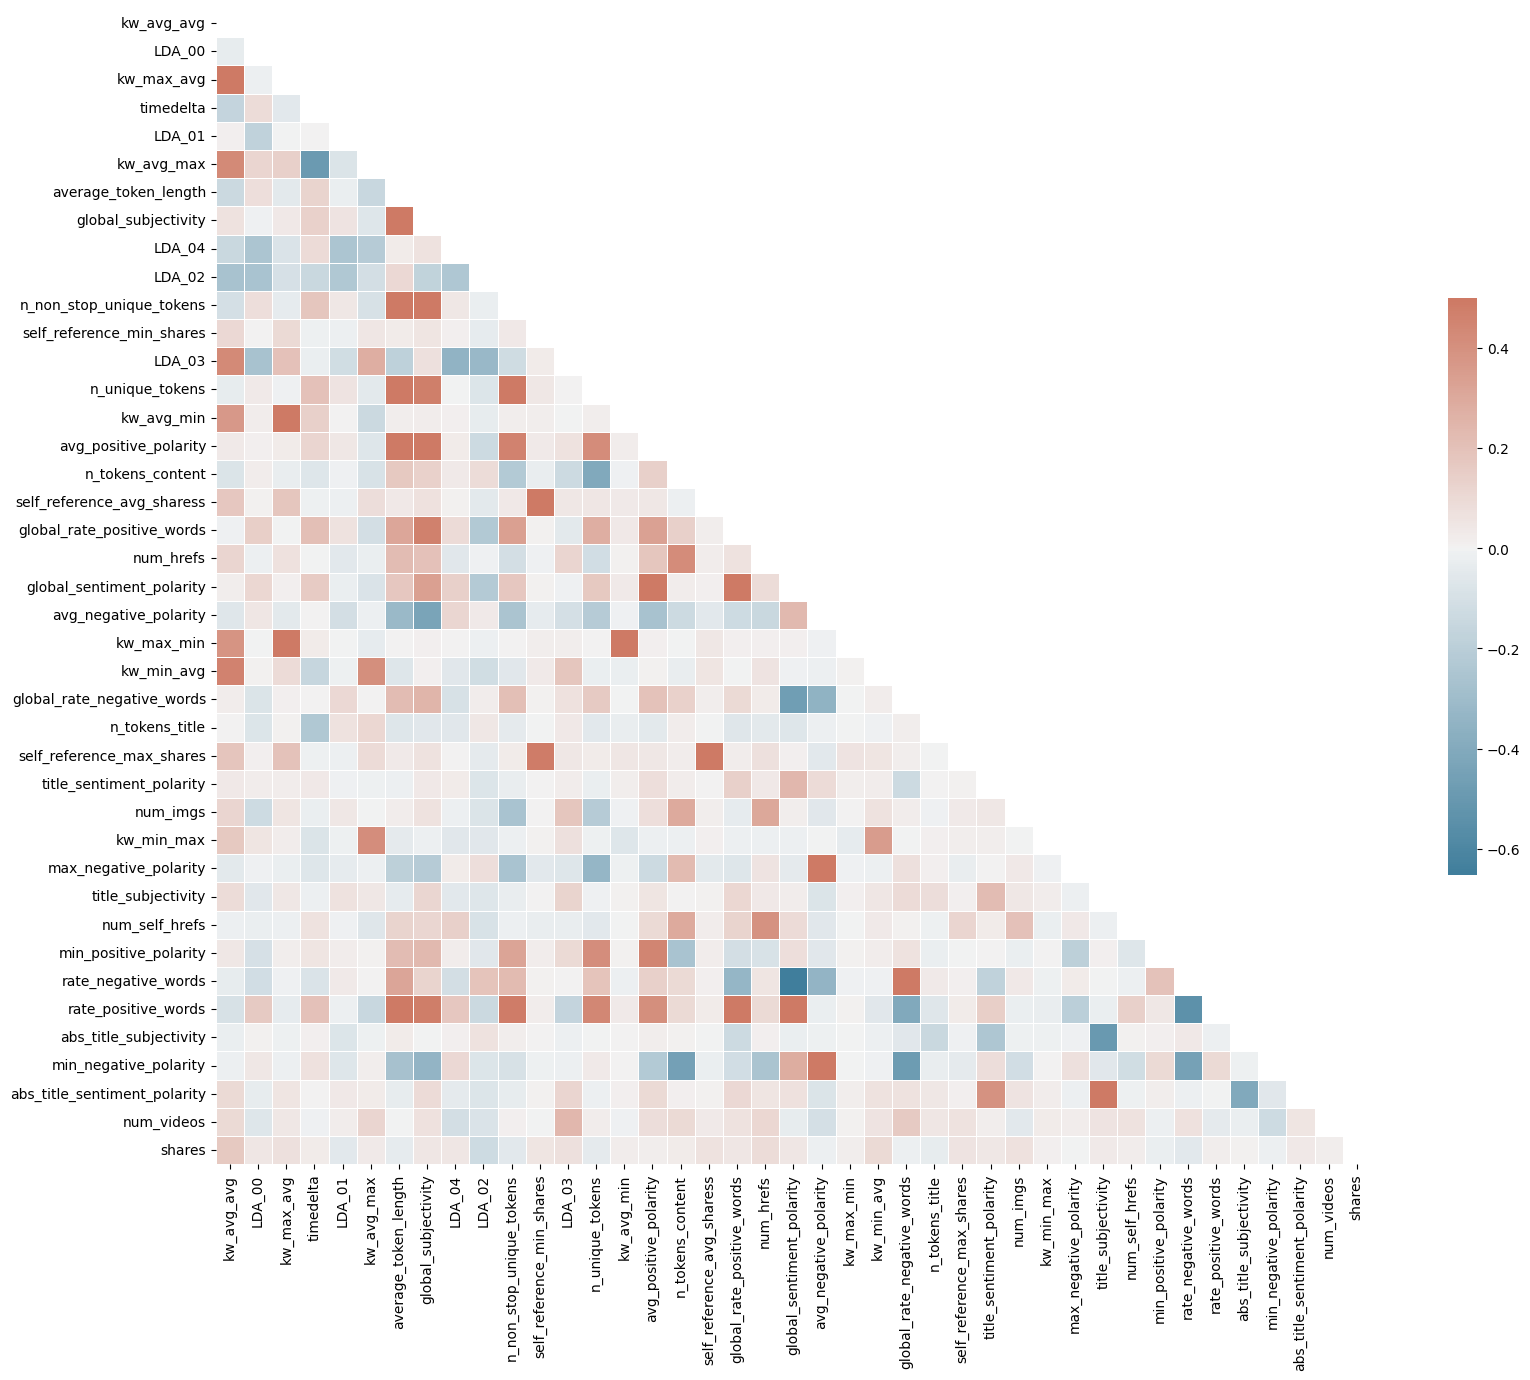

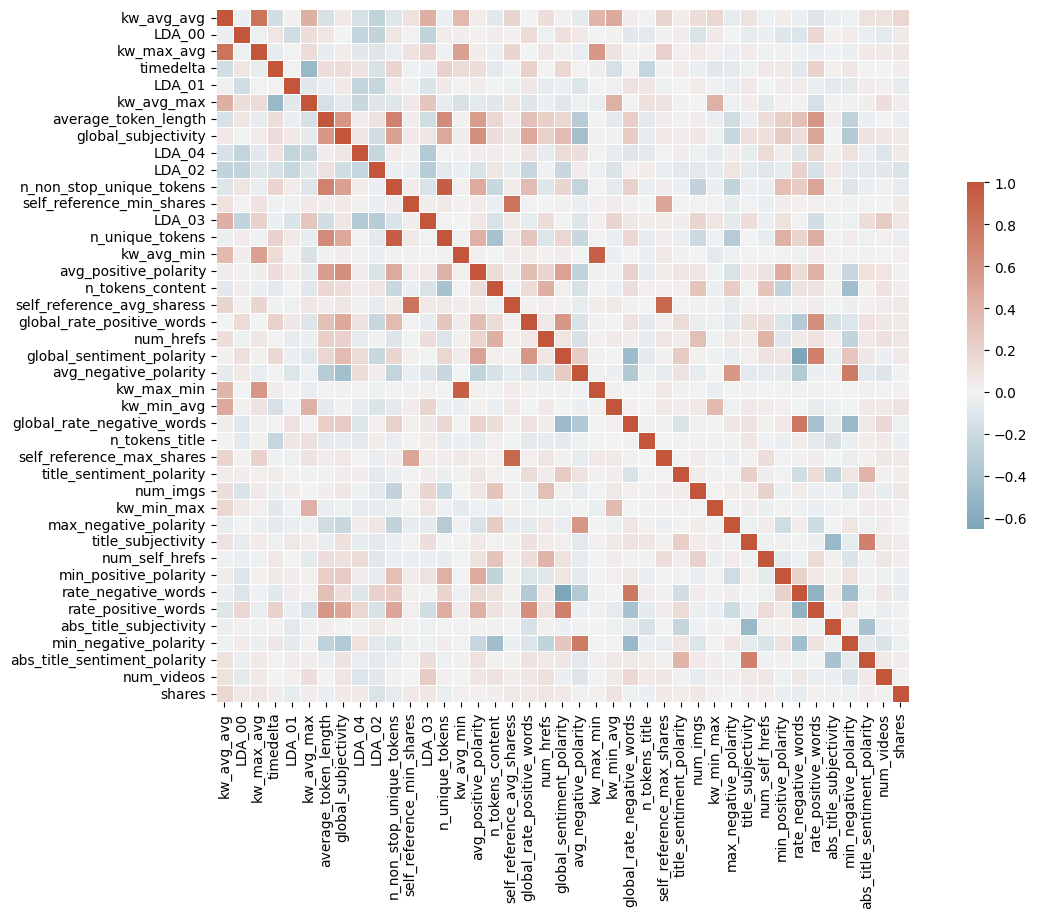

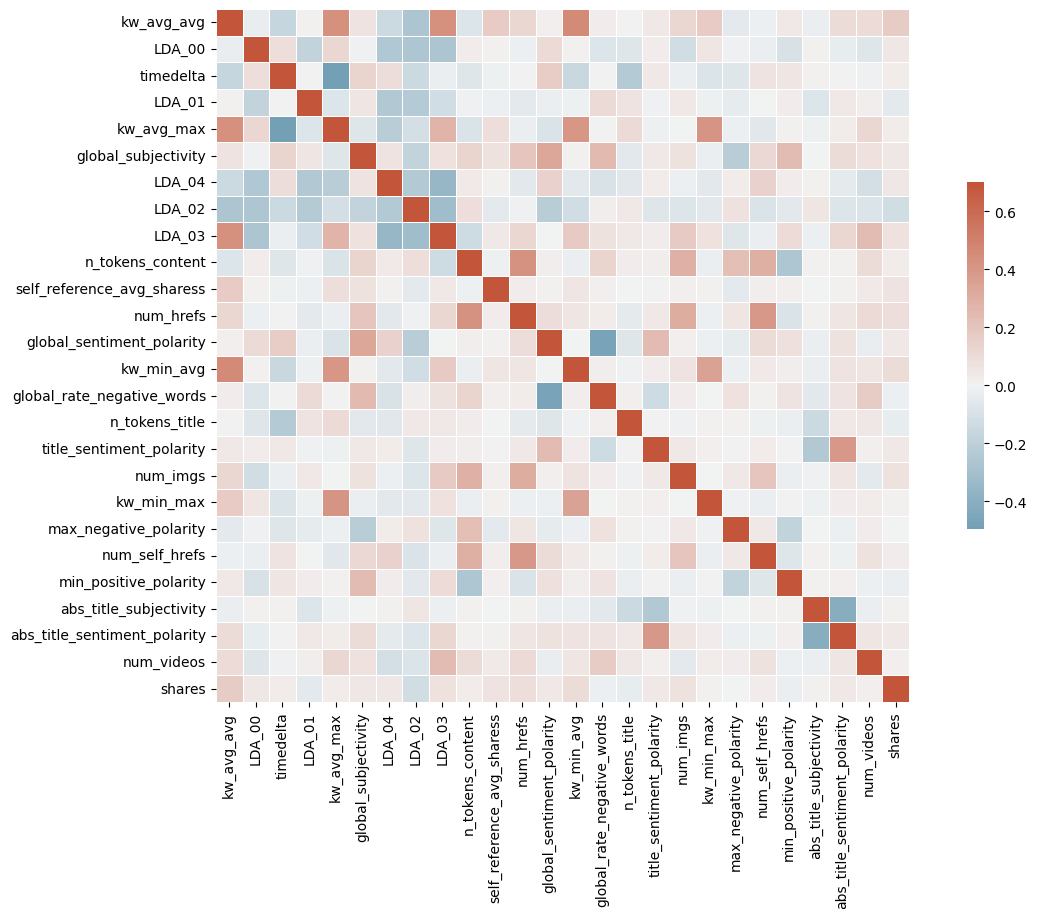

In [30]:
def corr_cut(X, lw_th=0.01, hi_th=0.7, verbose = 0):
    X['shares'] = y
    corr=X.corr()
    mask = np.triu(np.ones_like(corr, dtype=bool))
    if verbose:
        f, ax = plt.subplots(figsize=(20, 15))
        cmap = sns.diverging_palette(230, 20, as_cmap=True)
        sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.5, center=0,
                  square=True, linewidths=.5, cbar_kws={"shrink": .5})
    correlation_th = lw_th
    corr_shares=corr[abs(corr['shares']) >= correlation_th]
    if verbose:
        print(corr_shares['shares'])
    corr2=corr.loc[corr_shares['shares'].keys()][corr_shares['shares'].keys()]
    
    if verbose:
        f, ax = plt.subplots(figsize=(15, 9))
        cmap = sns.diverging_palette(230, 20, as_cmap=True)
        sns.heatmap(corr2, cmap=cmap, vmax=1, center=0,
                    square=True, linewidths=.5, cbar_kws={"shrink": .5})
    correlation_threshold = hi_th

    highly_correlated_pairs = np.where(np.abs(corr2) > correlation_threshold)
    highly_correlated_pairs = {(min(corr2.index[i], corr2.columns[j]), max(corr2.index[i], corr2.columns[j])) for i, j in zip(*highly_correlated_pairs) if i != j}
    for p in highly_correlated_pairs:
        if p[0]==p[1]:
            highly_correlated_pairs.remove(p)
    if verbose:
        print(highly_correlated_pairs)
        print(set(highly_correlated_pairs))
    # for each pair lets select the one with less correlation with shares and then remove them
    tobe_removed = []
    for p in highly_correlated_pairs:
        if corr_shares['shares'][p[0]] >= corr_shares['shares'][p[1]]:
            tobe_removed.append(p[1])
        else:
            tobe_removed.append(p[0])
    if verbose:
        print(tobe_removed)
    final_attributes_correlation_fix = list(filter(lambda x: x not in tobe_removed, corr_shares['shares'].keys()))
    if verbose:
        print(final_attributes_correlation_fix)
    corr3=corr.loc[final_attributes_correlation_fix][final_attributes_correlation_fix]
    

    f, ax = plt.subplots(figsize=(15, 9))
    cmap = sns.diverging_palette(230, 20, as_cmap=True)
    sns.heatmap(corr3, cmap=cmap, vmax=0.7, center=0,
                square=True, linewidths=.5, cbar_kws={"shrink": .5})
    final_attributes_correlation_fix.remove('shares')
    return final_attributes_correlation_fix
X['shares']=y_c
features = corr_cut(X[features_imp_columns],lw_th = 0.0, hi_th=0.5, verbose=1)
X_c = X[features]
X = X.drop(columns=['shares'])


In [31]:
len(features)



25

# Random Foprest

In [32]:
def print_diff(y_test,y_pred):

    sorted_indices = np.argsort(y_pred)
    sorted_y_pred = y_pred[sorted_indices]
    sorted_y_test = list(y_test.iloc[sorted_indices])

    plt.figure(figsize=(8, 6))  
    plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1)  
    plt.plot(sorted_y_test, sorted_y_pred, 'o',alpha=0.1, label='Predicted vs Actual')

    max_value = max(np.max(sorted_y_test), np.max(sorted_y_pred))
    plt.plot([0, max_value], [0, max_value], color='red', linestyle='--', label='Diagonal Line')

    plt.xlabel('Actual (Y)')
    plt.ylabel('Predicted (Y)')
    plt.title('Comparison of Predicted vs Actual Values')

    plt.legend()

    plt.show()


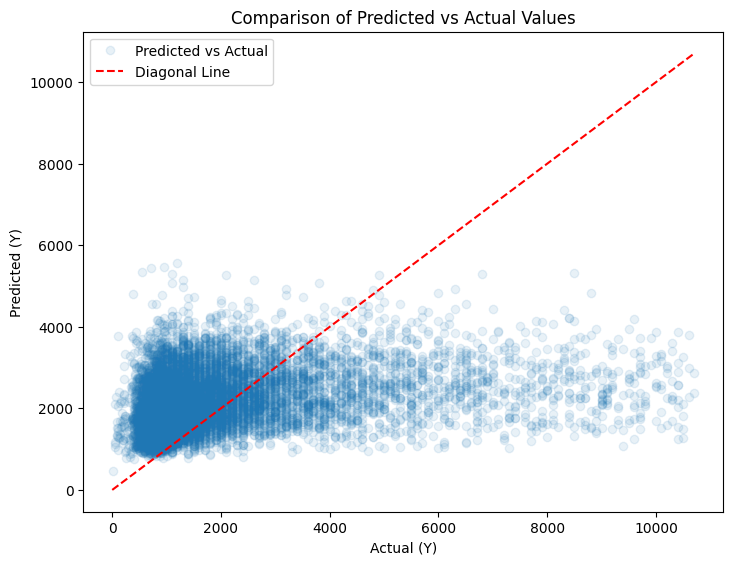

Root Mean Squared Error (RMSE): 1802.3885144152362


In [35]:

X_train, X_test, y_train, y_test = train_test_split(X[features], y_c,
                                                    test_size=0.3, random_state=42)

m_rf = RandomForestRegressor()

m_rf.fit(X_train, y_train)
y_pred = m_rf.predict(X_test)

rmse = mean_squared_error(y_test, y_pred, squared=False)
print_diff(y_test,y_pred)

print("Root Mean Squared Error (RMSE):", rmse)

<Axes: ylabel='Frequency'>

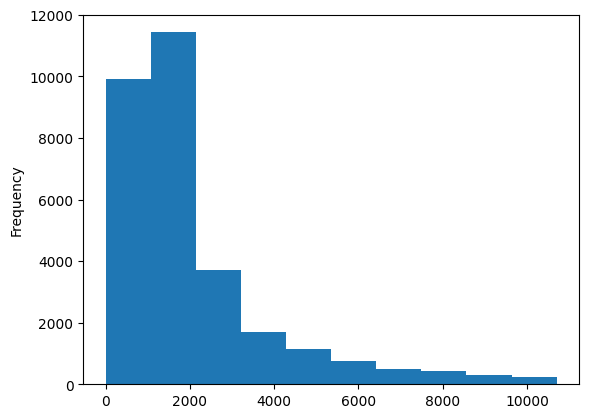

In [36]:
y_c.plot.hist()

6


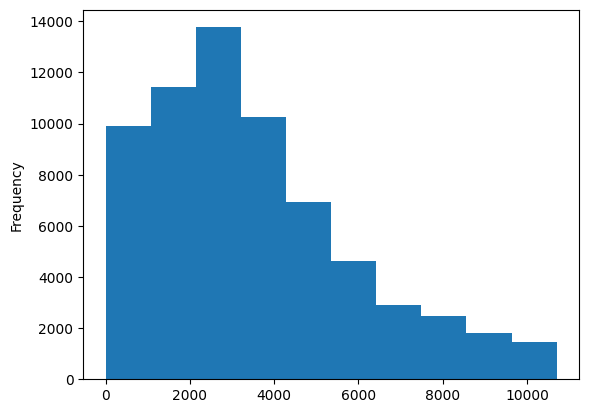

In [48]:
from sklearn.model_selection import GridSearchCV
def oversample(X_c, y, cut, mx=1):
    data_combined = pd.concat([X_c, y], axis=1)

    majority_class = data_combined[data_combined['shares'] <= cut]
    minority_class = data_combined[data_combined['shares'] > cut]

    num_samples = int((len(majority_class)/len(minority_class))*mx)
    print(num_samples)
    minority_oversampled = np.repeat(minority_class.values, num_samples, axis=0)

    data_oversampled = pd.DataFrame(np.vstack([majority_class.values, minority_oversampled]),
                                    columns=data_combined.columns)

    X_oversampled = data_oversampled.drop('shares', axis=1)
    y_oversampled = data_oversampled['shares']
    y_oversampled.plot.hist()

    X_oversampled.shape
    return X_oversampled, y_oversampled

X_oversampled, y_oversampled = oversample(X[features], y_c,cut=2500, mx=2)


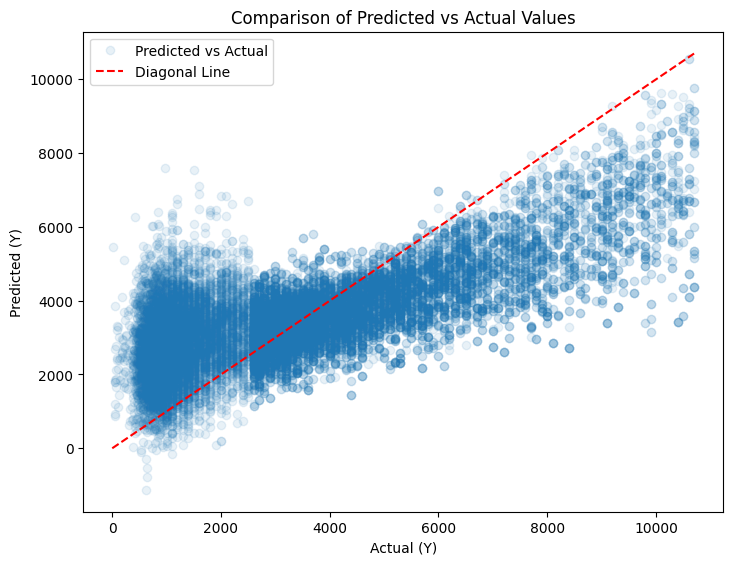

Root Mean Squared Error (RMSE): 1693.8772723591683


In [49]:

from xgboost import XGBRegressor


X_train, X_test, y_train, y_test = train_test_split(X_oversampled, y_oversampled,
                                                    test_size=0.3, random_state=42)

m_rf = XGBRegressor.XGBRegressor()

m_rf.fit(X_train, y_train)
y_pred = m_rf.predict(X_test)

rmse = mean_squared_error(y_test, y_pred, squared=False)
print_diff(y_test,y_pred)

print("Root Mean Squared Error (RMSE):", rmse)

2


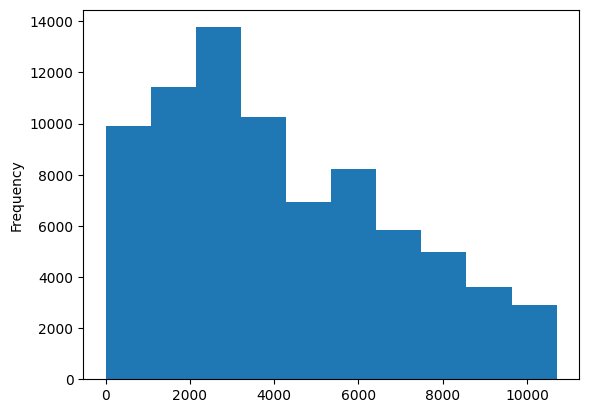

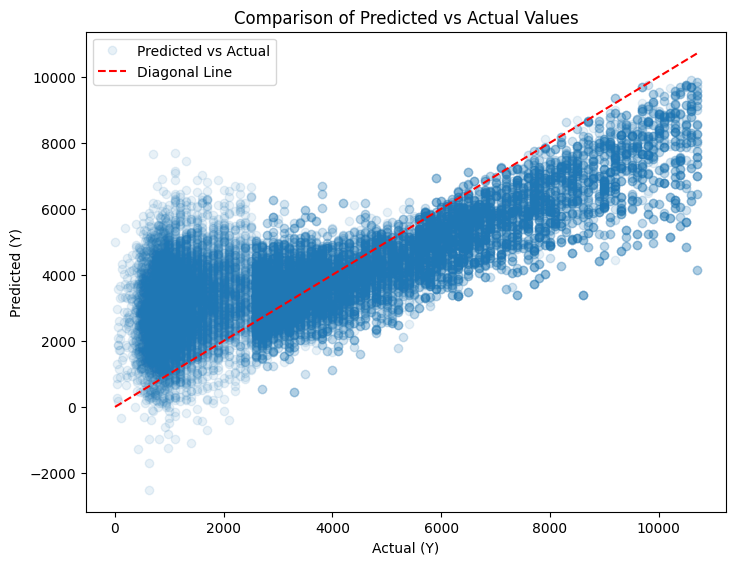

Root Mean Squared Error (RMSE): 1668.4017528860757


In [50]:

import xgboost as xgb
X_oversampled, y_oversampled = oversample(X_oversampled, y_oversampled,cut=5500, mx=0.5)

X_train, X_test, y_train, y_test = train_test_split(X_oversampled, y_oversampled,
                                                    test_size=0.3, random_state=42)

m_rf = xgb.XGBRegressor()

m_rf.fit(X_train, y_train)
y_pred = m_rf.predict(X_test)

rmse = mean_squared_error(y_test, y_pred, squared=False)
print_diff(y_test,y_pred)

print("Root Mean Squared Error (RMSE):", rmse)


# Hyperparameter tuning 

In [ ]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [2,3,4, 5],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 0.5]
}

rf_model = RandomForestRegressor(random_state=42)
grid_search =  RandomizedSearchCV(rf_model, param_distributions=param_grid, n_iter=10, cv=5, scoring='neg_root_mean_squared_error', n_jobs=-1)
grid_search.fit(X_train, y_train)
b_model = grid_search.best_estimator_

best_params = grid_search.best_params_
y_pred = b_model.predict(X_test)

rmse = mean_squared_error(y_test, y_pred, squared=False)
print_diff(y_test,y_pred)

print("Root Mean Squared Error (RMSE):", rmse)
print("Best Parameters: ", best_params)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/Users/alessandroferi/lab/.conda/lib/python3.8/site-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 1 is smaller than n_iter=20. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


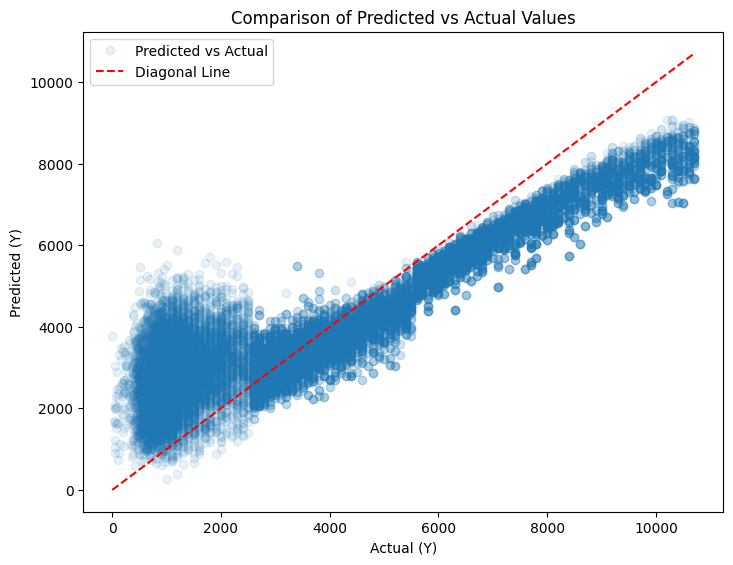

Root Mean Squared Error (RMSE): 1258.44260425944
Best Parameters:  {'subsample': 0.5, 'reg_lambda': 30, 'reg_alpha': 50, 'n_estimators': 250, 'min_child_weight': 14, 'max_depth': 25, 'learning_rate': 0.023, 'gamma': 2, 'colsample_bytree': 0.5}


In [189]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

xgb_model = xgb.XGBRegressor()

param_grid = {
    'max_depth': [10, 20, 25], 
    'learning_rate': [0.001, 0.01, 0.023],  
    'n_estimators': [100,200,250],  
    'subsample': [0.5, 0.7, 0.8],  
    'colsample_bytree': [0.5, 0.7, 0.3],  
    'min_child_weight': [10, 14, 18],
    'gamma': [1, 2, 3],  
    'reg_alpha': [ 50 ] , 
    'reg_lambda': [ 30]  
}

# Perform grid search with cross-validation
grid_search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_grid,
    scoring='neg_mean_squared_error',
    cv=5,
    verbose=1,
    n_jobs=-1,
    random_state=42,
    n_iter=20
)
grid_search.fit(X_train, y_train)
b_model = grid_search.best_estimator_

best_params = grid_search.best_params_
y_pred = b_model.predict(X_test)

rmse = mean_squared_error(y_test, y_pred, squared=False)
print_diff(y_test,y_pred)

print("Root Mean Squared Error (RMSE):", rmse)
print("Best Parameters: ", best_params)


Best Results:

Root Mean Squared Error (RMSE): 1977.3491338127844
Best Parameters:  {'subsample': 0.5, 'reg_lambda': 30, 'reg_alpha': 50, 'n_estimators': 250, 'min_child_weight': 14, 'max_depth': 25, 'learning_rate': 0.01, 'gamma': 2, 'colsample_bytree': 0.5}

# Evaluation

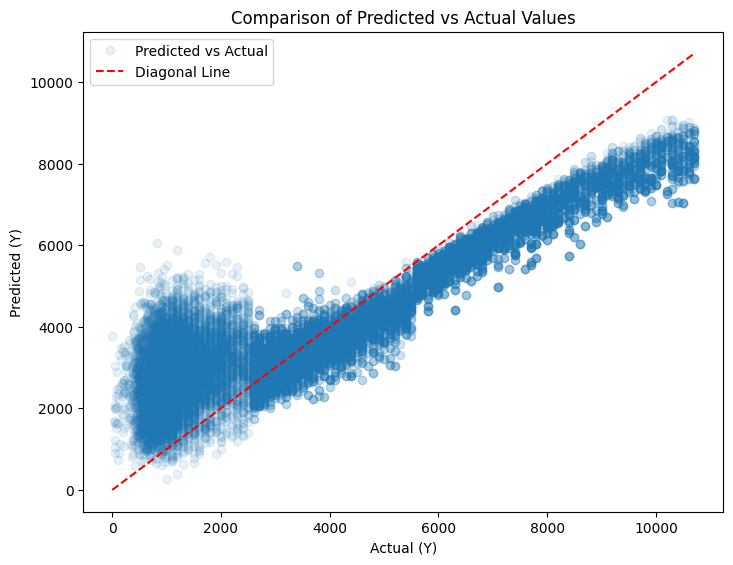

Root Mean Squared Error (RMSE): 1258.44260425944


In [190]:
data_eval = pd.read_csv("evaluation.csv",index_col=0)  
X_e = pd.get_dummies(data_eval)
X_e.fillna(0, inplace=True)

X_e[columns] = scaler.fit_transform(X_e[columns])
X_eval = X_e[features]
y_pred = b_model.predict(X_test)
rmse = mean_squared_error(y_test, y_pred, squared=False)
print_diff(y_test, y_pred)
print("Root Mean Squared Error (RMSE):", rmse)

y_pred = b_model.predict(X_eval)
df_submission = pd.DataFrame([], columns=['Id','Predicted']) 
df_submission['Predicted'] = y_pred
df_submission['Id'] = X_eval.index
df_submission.to_csv('submissionTESTfine.csv',index=False)